### Trabalho Final da Matéria de Processamento de Imagens - BCC FURB

<b>Turma:</b> SUP-CMP.187.0.2-2024/1<br>
<b>Docente:</b> Aurélio Faustino Hoppe<br>
<b>Discentes:</b> Arthur B Pinotti, Kaue Reblin, Luiz G Klitzke<br>

In [77]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [84]:
# Parâmetros

img_height, img_width = 256, 256
path_dataset = "Images"
labels_classes = ["Habitado", "NaoHabitado"]

In [85]:
#Obtem os datasets de treino e validação através da estrutura de pastas

train_dataset, validation_dataset  = keras.utils.image_dataset_from_directory(
    path_dataset,
    labels = "inferred",
    label_mode = "int",
    class_names = labels_classes,
    color_mode = "rgb",
    batch_size = 32,
    image_size = (img_height, img_width),
    shuffle = True,
    validation_split = 0.3, #Usa n% de dados para validação
    subset = "both",
    verbose =  True,
    seed = 1024,
)

Found 486 files belonging to 2 classes.
Using 341 files for training.
Using 145 files for validation.


In [ ]:
cnn = keras.models.Sequential()

cnn.add(keras.layers.InputLayer(input_shape=(img_height, img_width, 3)))

cnn.add(keras.layers.Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
cnn.add(keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'))

cnn.add(keras.layers.Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
cnn.add(keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

cnn.add(keras.layers.Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
cnn.add(keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'))
cnn.add(keras.layers.BatchNormalization())

cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(units=100, activation='relu'))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Dense(units=100, activation='relu'))
cnn.add(keras.layers.Dropout(0.25))

# output layer
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

c:\Users\luizk\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_113 (Conv2D)             │ (None, 256, 256, 25)   │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 128, 128, 25)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 64, 64, 50)     │        31,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 32, 32, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 16, 16, 70)     │        31,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 8, 8, 70)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 70)       │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 4480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 100)            │       448,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,551 (2.00 MB)

 Trainable params: 523,311 (2.00 MB)

 Non-trainable params: 240 (960.00 B)

In [95]:
# Compilação do cnno
cnn.compile(
    loss='binary_crossentropy', #https://keras.io/api/losses/probabilistic_losses/#sparse_categorical_crossentropy-function
    optimizer='adam', #https://keras.io/api/optimizers/
    metrics=['accuracy']
)

# Treinamento do cnno
history_cnn = cnn.fit(
    train_dataset,
    epochs = 30,
    validation_data = validation_dataset,
)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - accuracy: 0.9300 - loss: 0.2040 - val_accuracy: 0.6759 - val_loss: 11.5485
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.9172 - loss: 0.2009 - val_accuracy: 0.7517 - val_loss: 5.1892
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.9349 - loss: 0.1658 - val_accuracy: 0.7310 - val_loss: 5.5733
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 383ms/step - accuracy: 0.9412 - loss: 0.1664 - val_accuracy: 0.8483 - val_loss: 0.9742
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - accuracy: 0.9643 - loss: 0.1141 - val_accuracy: 0.7586 - val_loss: 9.4791
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - accuracy: 0.9222 - loss: 0.1950 - val_accuracy: 0.7793 - val_loss: 4.8196
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 434ms/step - accuracy: 0.9502 - loss: 0.1428 - val_accuracy: 0.8069 - val_loss: 3.3361
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.9414 - loss: 0.1599 - val_accuracy: 0

In [91]:
# Avaliação do cnno
loss, accuracy = cnn.evaluate(validation_dataset, verbose = 1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8618 - loss: 0.4238


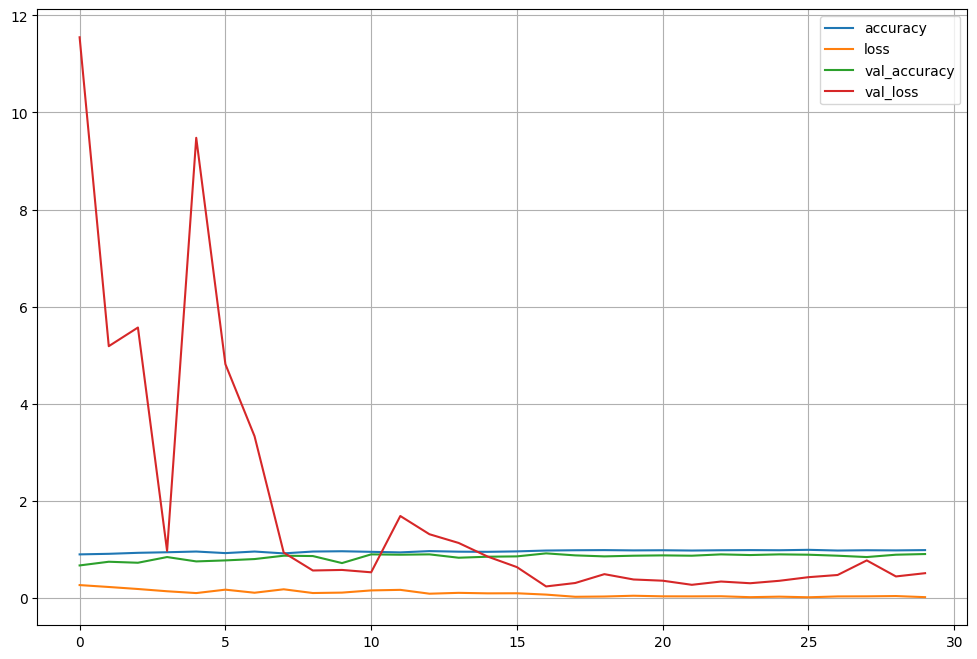

In [98]:
#Apresenta os dados da performânce do algoritmo, atráves do membro history, preenchido com a execução.
pd.DataFrame(history_cnn.history).plot(figsize=(12, 8))
plt.grid(True)
plt.show()